In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image ,ImageDraw
plt.ioff()

In [17]:
#Creating the image class to ease the operations and to maintain clean code
class ImageClass:
    
    def __init__(self,image):
         # Convert to grayscale
        self.grayscale_image = image.convert('L')
        self.image_array = np.array(self.grayscale_image)
        self.image=image
        self.height,self.width=self.image_array.shape
    #calculate threshold for the image based on the pixel value of each pixel in the image
    def thresh_hold(self):
        
        threshold = 128  # this value can be adjusted by looking at the histogram
        binary_image = np.where(self.image_array > threshold, 255, 0).astype(np.uint8)
        thresholded_image = Image.fromarray(binary_image)
        return thresholded_image
        
    #turn image to grayscale
    def to_gray_scale(self):
        
        return self.grayscale_image
        
    #turns image into halftoned image
    def halftone(self):
        
        dot_size=10
        halftone_image = Image.new('L', (self.width, self.height), 255)  # white background
        draw = ImageDraw.Draw(halftone_image)
        for y in range(0, self.height, dot_size):
                for x in range(0, self.width, dot_size):
                # Extract the block
                    block = self.image_array[y:y+dot_size, x:x+dot_size]

            # Calculate the average intensity of the block
                    average_intensity = np.mean(block)

            # Map intensity to circle size
                    radius = int((255 - average_intensity) / 255 * (dot_size / 2))

            # Draw the circle
                    center = (x + dot_size // 2, y + dot_size // 2)
                    draw.ellipse(
                        [center[0] - radius, center[1] - radius,
                        center[0] + radius, center[1] + radius],
                        fill=0 #black dots
                                            )
        return halftone_image
            

    #this function gets the histogram of the image
    def get_histogram(self):

        pixel_value=self.image_array.flatten()
        fig,ax=plt.subplots()
        ax.hist(pixel_value,bins=256,range=(0,256),color='gray',alpha=0.7)
        ax.set_title("GrayScale Histogram")
        ax.set_xlabel("Intensity")
        ax.set_ylabel("Frequency")
        return fig
    
    
    #the operation parameter controls if you want to use sobel,prewitt or use kirsch 
    def simple(self,operation):
        
        
        padded_image=np.pad(self.image_array,((1,1),(1,1)),mode="constant",constant_values=0)
        if operation =='sobel':
            sobel_x = np.array([[-1, 0, 1],
                                [-1, 0, 1],
                                [-1, 0, 1]], dtype=np.float32)
            sobel_y = np.array([[-1, -1, -1],
                                 [0,  0,  0],
                                [1,  1,  1]], dtype=np.float32)

            grad_x = (
            sobel_x[0, 0] * padded_image[:-2, :-2] +
            sobel_x[0, 1] * padded_image[:-2, 1:-1] +
            sobel_x[0, 2] * padded_image[:-2, 2:] +
            sobel_x[1, 0] * padded_image[1:-1, :-2] +
            sobel_x[1, 1] * padded_image[1:-1, 1:-1] +
            sobel_x[1, 2] * padded_image[1:-1, 2:] +
            sobel_x[2, 0] * padded_image[2:, :-2] +
            sobel_x[2, 1] * padded_image[2:, 1:-1] +
            sobel_x[2, 2] * padded_image[2:, 2:]
        )
            grad_y = (
            sobel_y[0, 0] * padded_image[:-2, :-2] +
            sobel_y[0, 1] * padded_image[:-2, 1:-1] +
            sobel_y[0, 2] * padded_image[:-2, 2:] +
            sobel_y[1, 0] * padded_image[1:-1, :-2] +
            sobel_y[1, 1] * padded_image[1:-1, 1:-1] +
            sobel_y[1, 2] * padded_image[1:-1, 2:] +
            sobel_y[2, 0] * padded_image[2:, :-2] +
            sobel_y[2, 1] * padded_image[2:, 1:-1] +
            sobel_y[2, 2] * padded_image[2:, 2:]
        )
        elif operation=="prewitt":
            
            prewitt_x = np.array([[-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]], dtype=np.float32)
            prewitt_y = np.array([ [-1, -2, -1],
                                   [0,  0,  0],
                                   [1,  2,  1]], dtype=np.float32)
            grad_x = (
            prewitt_x[0, 0] * padded_image[:-2, :-2] +
            prewitt_x[0, 1] * padded_image[:-2, 1:-1] +
            prewitt_x[0, 2] * padded_image[:-2, 2:] +
            prewitt_x[1, 0] * padded_image[1:-1, :-2] +
            prewitt_x[1, 1] * padded_image[1:-1, 1:-1] +
            prewitt_x[1, 2] * padded_image[1:-1, 2:] +
            prewitt_x[2, 0] * padded_image[2:, :-2] +
            prewitt_x[2, 1] * padded_image[2:, 1:-1] +
            prewitt_x[2, 2] * padded_image[2:, 2:]
    )

            grad_y = (
            prewitt_y[0, 0] * padded_image[:-2, :-2] +
            prewitt_y[0, 1] * padded_image[:-2, 1:-1] +
            prewitt_y[0, 2] * padded_image[:-2, 2:] +
            prewitt_y[1, 0] * padded_image[1:-1, :-2] +
            prewitt_y[1, 1] * padded_image[1:-1, 1:-1] +
            prewitt_y[1, 2] * padded_image[1:-1, 2:] +
            prewitt_y[2, 0] * padded_image[2:, :-2] +
            prewitt_y[2, 1] * padded_image[2:, 1:-1] +
            prewitt_y[2, 2] * padded_image[2:, 2:]
        ) 
        # Compute gradient magnitude
        grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Normalize the magnitude to 0-255
        grad_magnitude = (grad_magnitude / grad_magnitude.max()) * 255

    # turn to an image
        kernelized_image = Image.fromarray(grad_magnitude.astype(np.uint8))
        return kernelized_image

        
    #the operation parameter controls the various techqinues of advanced edge detection
    def advanced(self,operation):
        #define parameters
        window_size=3
        offset = window_size // 2
        hd_image = np.zeros_like(self.image_array)
        if operation=='homogenity':
            for y in range(offset, self.height - offset):
                for x in range(offset, self.width - offset):
            # Extract the local neighborhood (window) around the current pixel
                    window = self.image_array[y - offset:y + offset + 1, x - offset:x + offset + 1]
                    
            #local variance (contrast)
                    variance = np.var(window)
                    contrast = np.sqrt(variance)
                    
            #inverse of contrast
                    homogeneity = 1 / (contrast + 1e-5)  # Add small epsilon to avoid division by zero
                    
            #the homogeneity value to the output
                    hd_image[y, x] = homogeneity * 255  # Scale to 0-255 for display
                    
    # normalize
            hd_image = np.uint8(hd_image / np.max(hd_image) * 255)

        elif operation=="diffrence":
            for y in range(offset, self.height - offset):
                for x in range(offset, self.width - offset):
            # extract the local neighborhood (window) around the current pixel
                    window = self.image_array[y - offset:y + offset + 1, x - offset:x + offset + 1]
            
            # compute the maximum and minimum intensities in the window
                    max_intensity = np.max(window)
                    min_intensity = np.min(window)
            
            # calculate the intensity difference
                    difference = max_intensity - min_intensity
            
            # assign the difference value to the output image
                    hd_image[y, x] = difference

    # normalize the output to ensure the values are within 0-255
            hd_image = np.uint8(hd_image / np.max(hd_image) * 255)
        elif operation=="DoG":
            pass
            
            
    #the level parameter controls the level of the filer used high low or median
    def filtering(self,level):
        pass
    #this function does one of 3 thing it creates a copy of the image and either add it to the image itself or subtract image from itself or invert the image
    def operations(self,operation):
        image_copy=self.image_array.copy()
        if operation=="add":
            added_array=np.clip(self.image_array+image_copy,0,255)
            added_image=Image.fromarray(added_array)
            return added_image
        elif operation=="subtract":
            sub_array=np.clip(self.image_array-image_copy,0,255)
            sub_image=Image.fromarray(sub_array)
            return sub_image
        elif operation=="invert":
            inverted_array=255-self.image_array
            inverted_image=Image.fromarray(inverted_array)
            return inverted_image
    #this function either performs the manual, adaptive,histogram valley or histogram technique to detect edges
    def histogram_segmentation(self,operation):
        pass

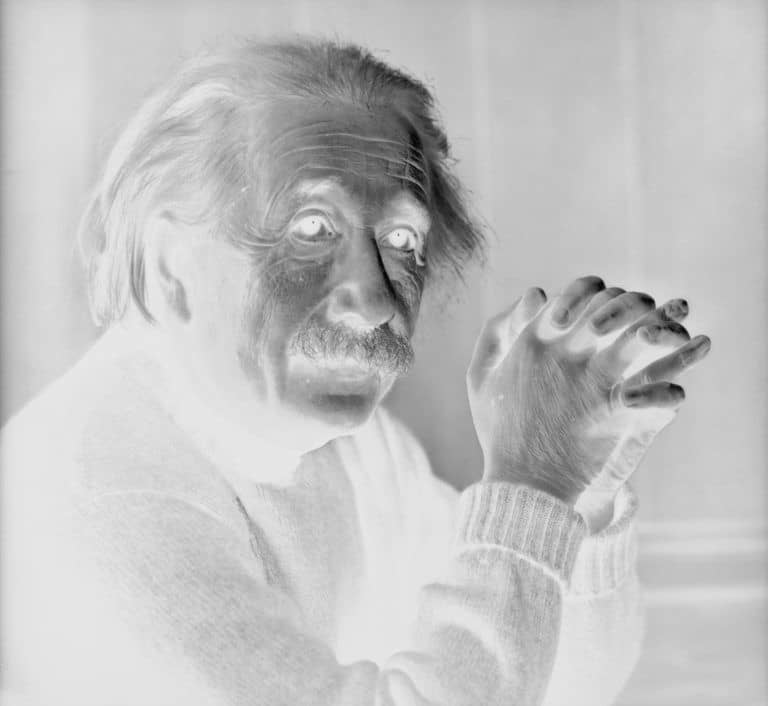

In [19]:
I1=ImageClass(Image.open('test1.jpg'))
I1.operations(operation="invert")